In [174]:
%matplotlib inline
import matplotlib.pylab as pl

import pandas as pd
import numpy as np

import sklearn as sk
import contextlib
import statsmodels.api as sm
import scipy.signal
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import decomposition


sns.set()

In [138]:
#http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
#set a function to manage the print options of specific arrays
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

**Import Data, Check Healthiness, Verify Can Drop NAs**

(this is a preliminary run through, using only NY County, All Industry Sectors, quarterly data from 2000 - 2014)

In [139]:
#reading in QWI indicators for the 4 counties in NYC (New York, Kings)

df = pd.read_csv('~/Documents/GRA/QWI_indicators/qwi_5c2543d712bc416f82683ab99e1517f6.csv')

In [140]:
#print out a list of columns
#df.columns

In [141]:
#remove the flags, which have a lowercase s followed by a capitalized column name
columns_no_flags = [word for word in df.columns if not word[1].isupper()]

#subset to new DF with no flags
df = df[columns_no_flags]
df.columns = [x.replace('.','_') for x in df.columns]

In [142]:
def print_full(x):
    #this function takes in a dataframe and prints the head of the df with all columns displayed
    #it then resets back to the default column display afterwards
    pd.set_option('display.max_columns', 500)
    print(x.head(10))
    pd.reset_option('display.max_columns')
    
#print_full(df)
#df.dtypes

In [143]:
#create new column 'period' that maps the year and quarter
df['period'] = df.year.map(str) + "_" + df.quarter.map(str)


In [144]:
#want data for Manhattan (county = 'New York, NY')
df_ny = df[df.geography_label_value == 'New York, NY']
#only using data from all industries in this example
mask = (df_ny.industry == '00')
df_ny_all = df_ny[mask]
#set the period as the index, so we can keep it when we go to all numerics
df_ny_all = df_ny_all.set_index(df_ny_all.period)


In [145]:
#select numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data = df_ny_all.select_dtypes(include=numerics)

#move period back from index
data.reset_index(level=0, inplace=True)



In [146]:
#drop geography, sex, firmage, firmsize
data.drop(['geography', 'sex', 'firmage', 'firmsize'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


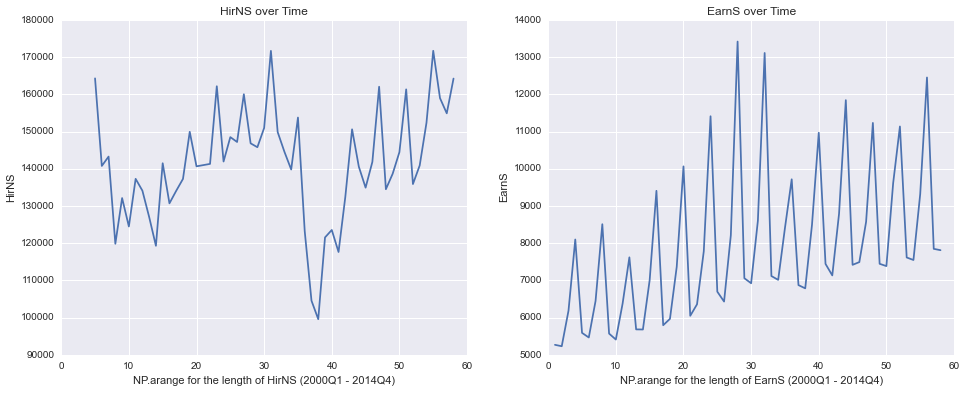

In [147]:
#before drop the NANs, verify position
#from printout, can see there are 6 in HirNS, 2 in EarnS

#check number of NaNs before Drop the values
#print(data.isnull().sum())

#points_ax1 = np.arange(len(data.HirNS))

fig, ((ax1, ax2)) = pl.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirNS)), data.HirNS, label = 'all data')
ax1.set_xlabel('NP.arange for the length of HirNS (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirNS')
ax1.set_title('HirNS over Time')

ax2.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'all data')
ax2.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax2.set_ylabel('EarnS')
ax2.set_title('EarnS over Time')


#based off the graph below, these are in early 2000 and then again in late 2014. Can now drop them
data = data.dropna()
data = data.reset_index()

In [148]:
data.index = pd.Index(pd.date_range(pd.to_datetime('04/1/2001'), pd.to_datetime('06/30/2014'),freq='Q'))

In [149]:
#cacluate percent change in new hires and add to dataframe
HirN_per = [0]
for i in np.arange(len(data['HirN'])-1):
#    while i < max(np.arange(len(data['HirN']))):
    #for i in len[data.HirN]:
    change = (data.ix[i+1,'HirN'] - data.ix[i,'HirN'])/data.ix[i,'HirN']
    HirN_per.append(change)
#print (HirN_per)

data['HirN_per'] = HirN_per

In [150]:
# add in NY county unemployment rates
df = pd.read_excel('/Users/carlyle/Documents/GRA/QWI_indicators/ny_county_uer.xlsx')
df = df.ix[5:57]
data['NYC_UER'] = (df['ny_uer'].values/100)

**Scatter Matrix and Basic Data Visualization**

In [151]:
#sns.pairplot(data, hue = 'quarter')

In [152]:
cols = list(data.columns)[4:-2]

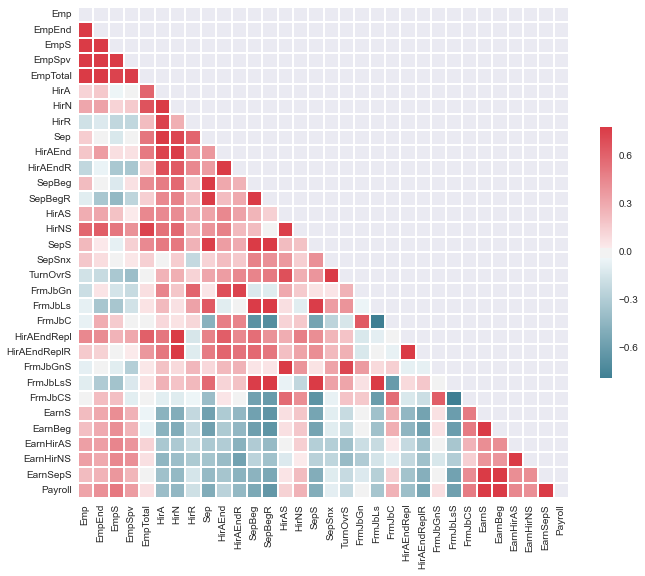

In [153]:
#Correlation Matrix for input variables

# Compute the correlation matrix
corr = data[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = pl.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, #xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [154]:
# fig = pl.figure(figsize=(25,60))
# fig.suptitle('LEHD var vs % Change in New Hires', fontweight='bold', fontsize=26)

# x = 1
# for i in cols:
#     ax1 = fig.add_subplot(11,3,x)
#     fig.tight_layout()
#     ax1.scatter(data[i], data['HirN_per'])
#     ax1.set_ylabel("HirN_per", fontsize = 14)
#     plt.xticks(rotation = 70)
#     ax1.set_title(i, fontsize=20, color='r')
#     x +=1

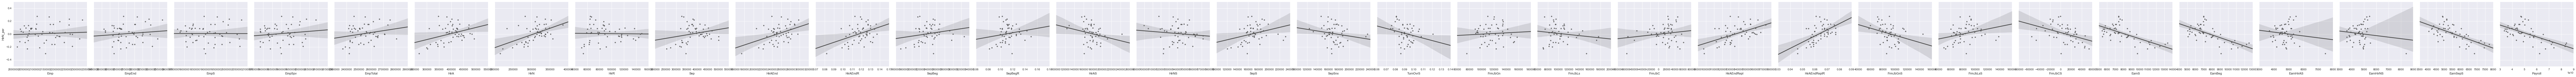

In [155]:
# Every input variable vs. Percent change in new hires
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["HirN_per"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-0.5, 0.5))

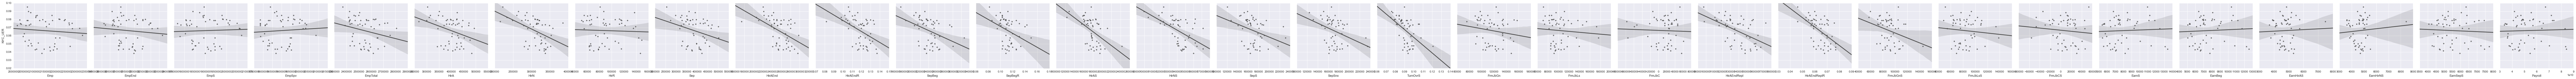

In [156]:
# Every input variable vs. Unemployment Rates
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["NYC_UER"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(0.02, 0.1))

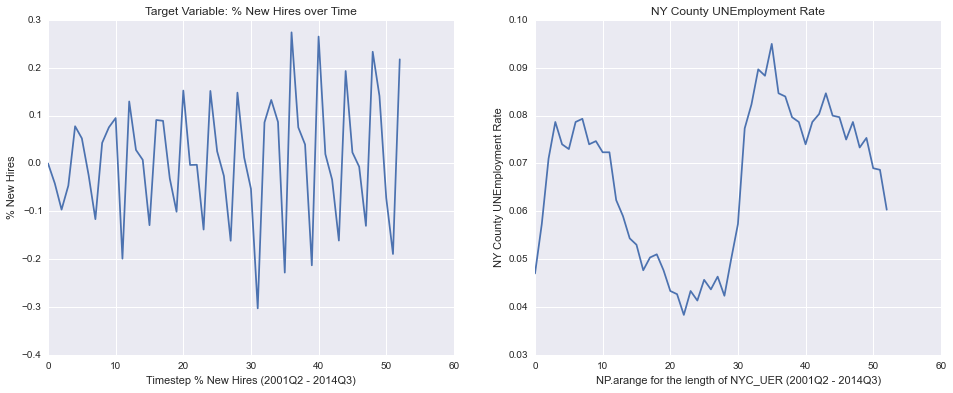

In [157]:
fig, ((ax1, ax2)) = pl.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirN_per)), data.HirN_per, label = 'all data')
ax1.set_xlabel('Timestep % New Hires (2001Q2 - 2014Q3)')
ax1.set_ylabel('% New Hires')
ax1.set_title('Target Variable: % New Hires over Time')

ax2.plot(np.arange(len(data.NYC_UER)), data.NYC_UER, label = 'all data')
ax2.set_xlabel('NP.arange for the length of NYC_UER (2001Q2 - 2014Q3)')
ax2.set_ylabel('NY County UNEmployment Rate')
ax2.set_title('NY County UNEmployment Rate')


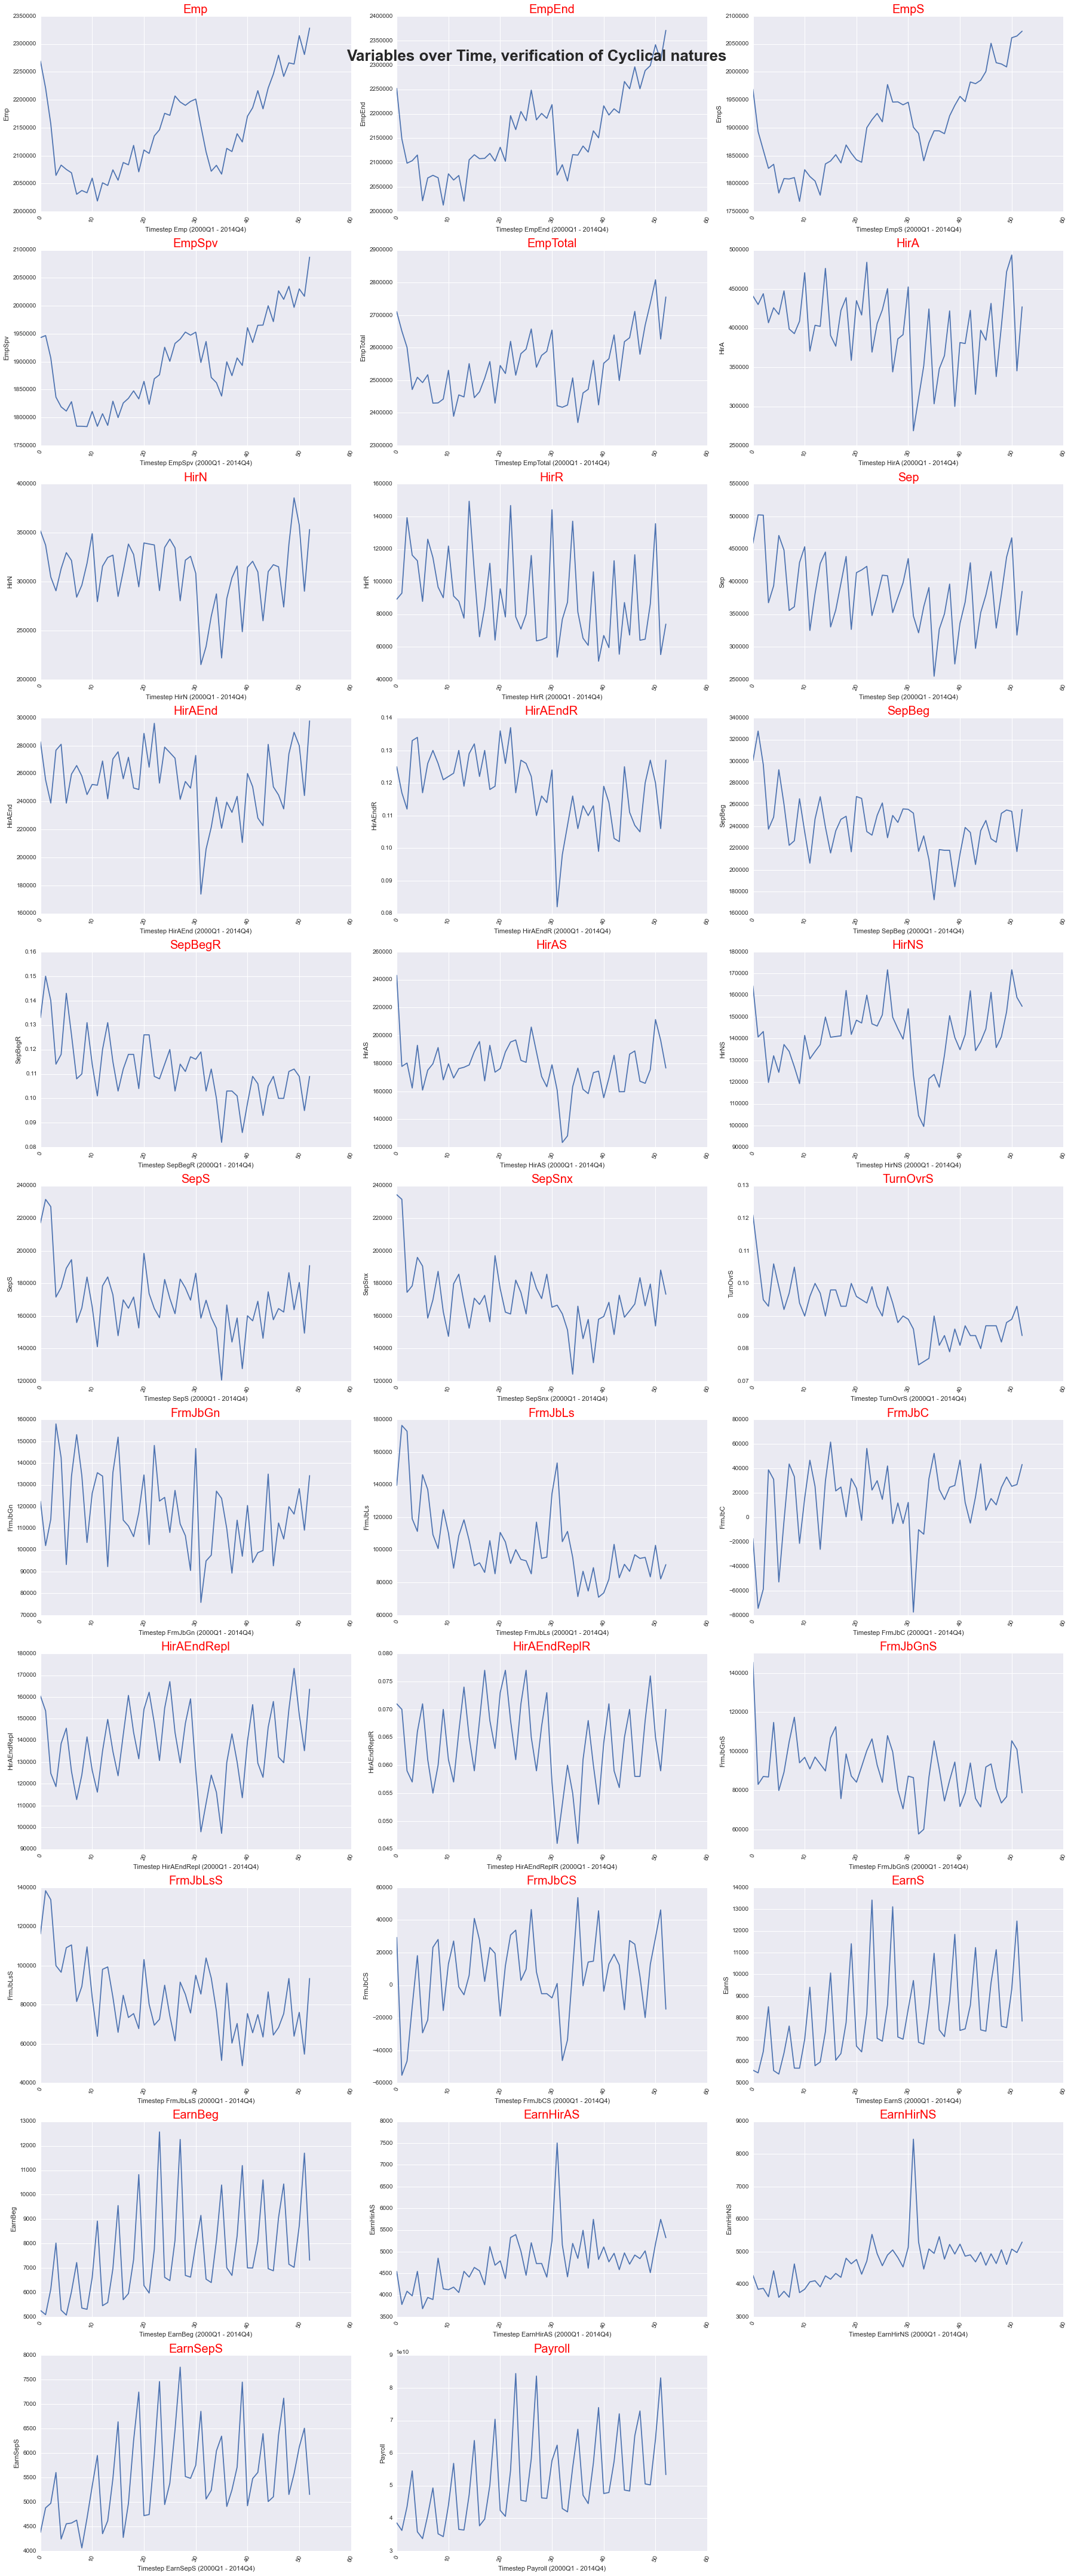

In [158]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, verification of Cyclical natures', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(np.arange(len(data[i])), data[i], label = 'all data')
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

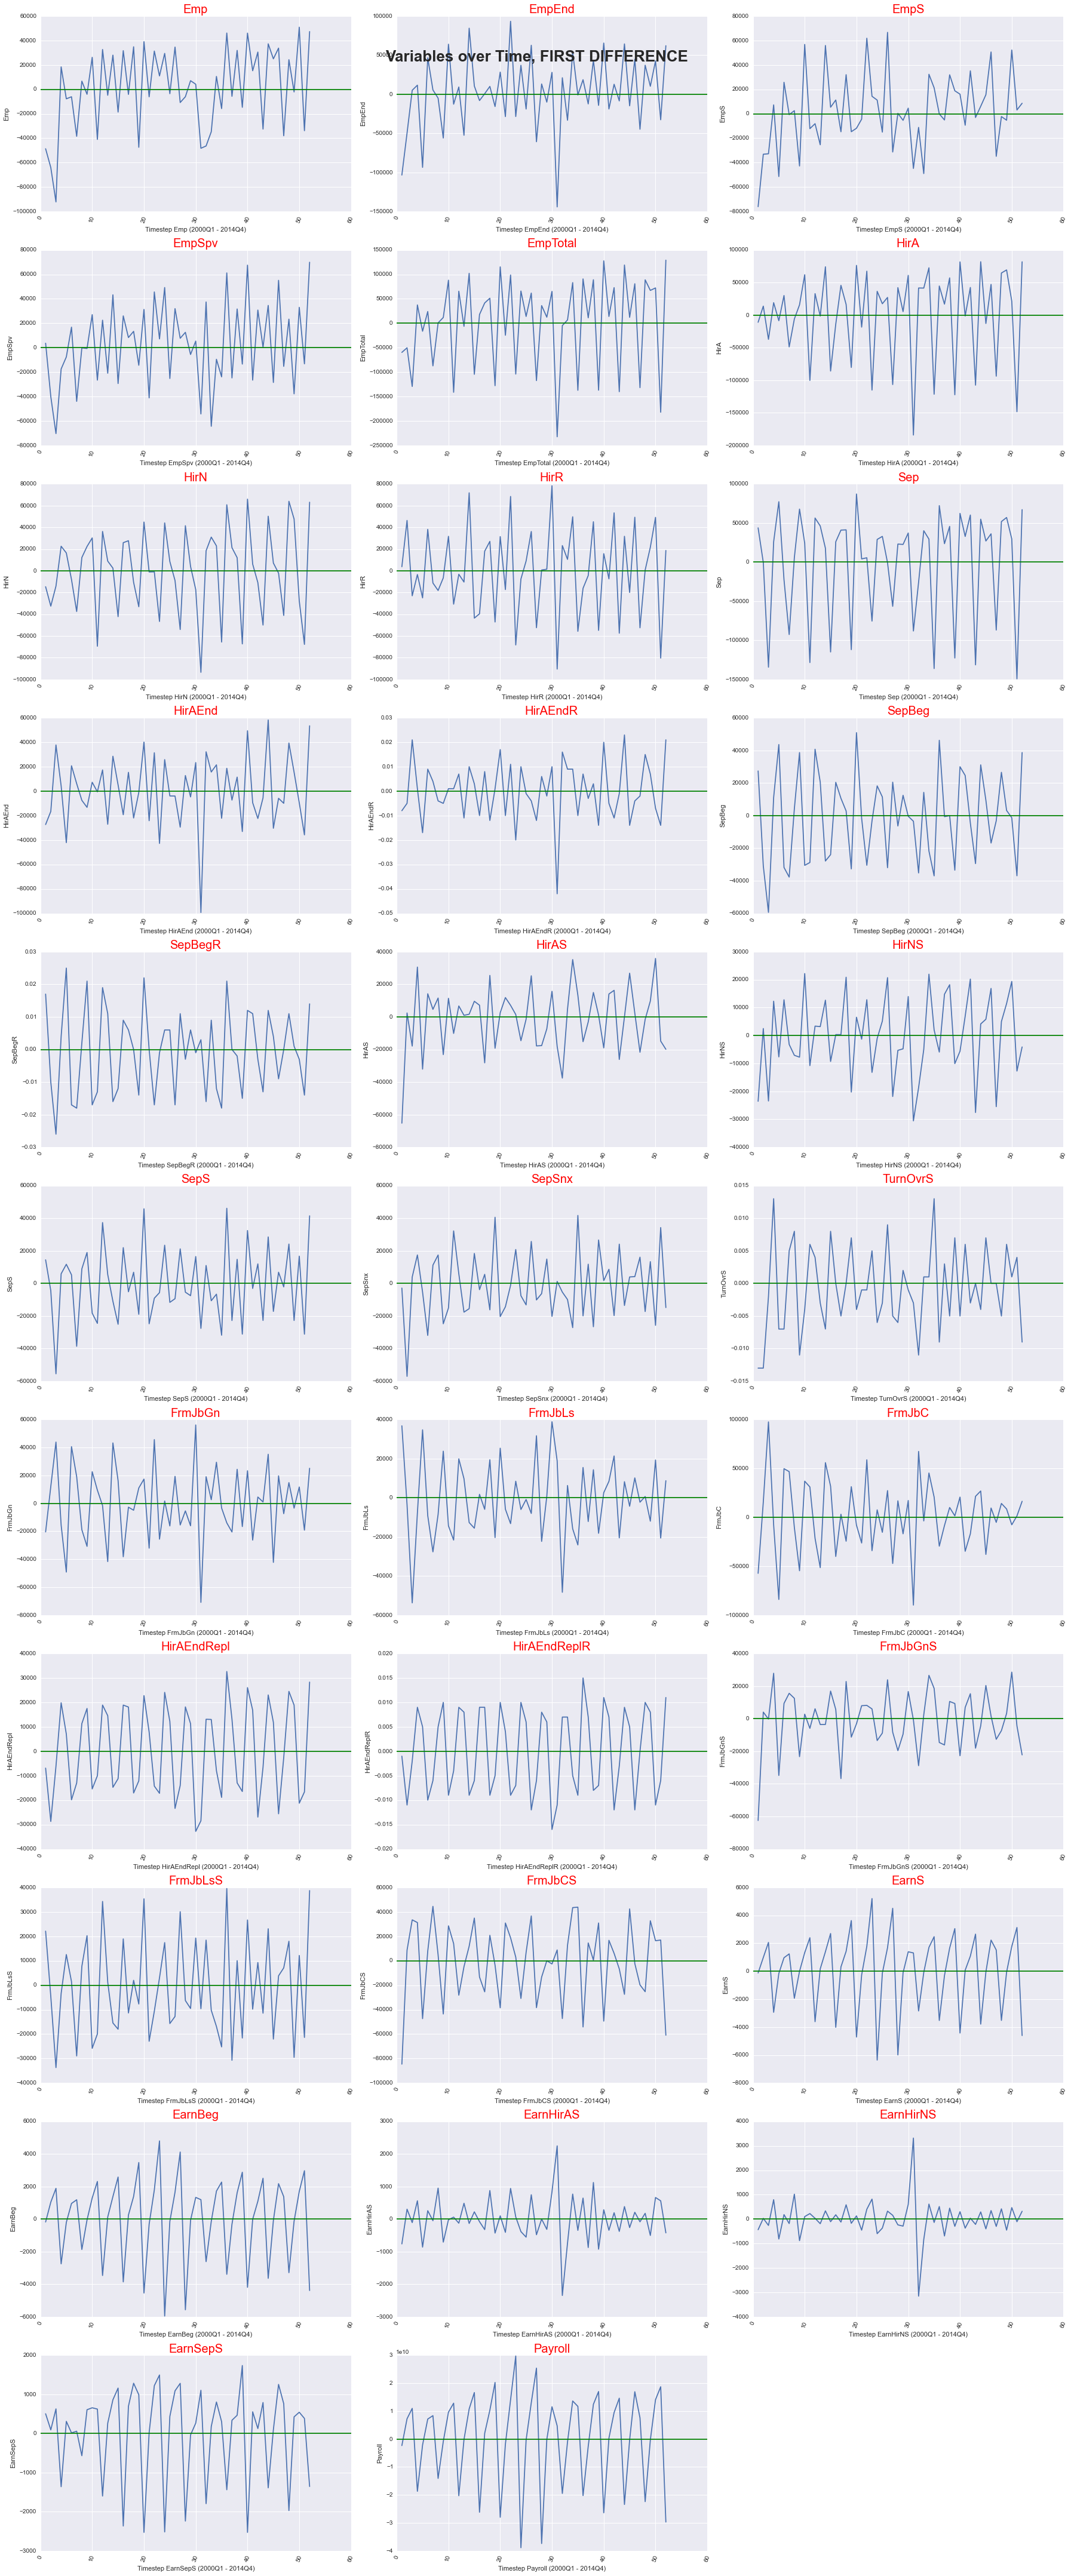

In [159]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, FIRST DIFFERENCE', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(np.arange(len(data[i])), data[i] - data[i].shift(), label = 'all data')
    ax1.axhline(0, color = 'g')
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

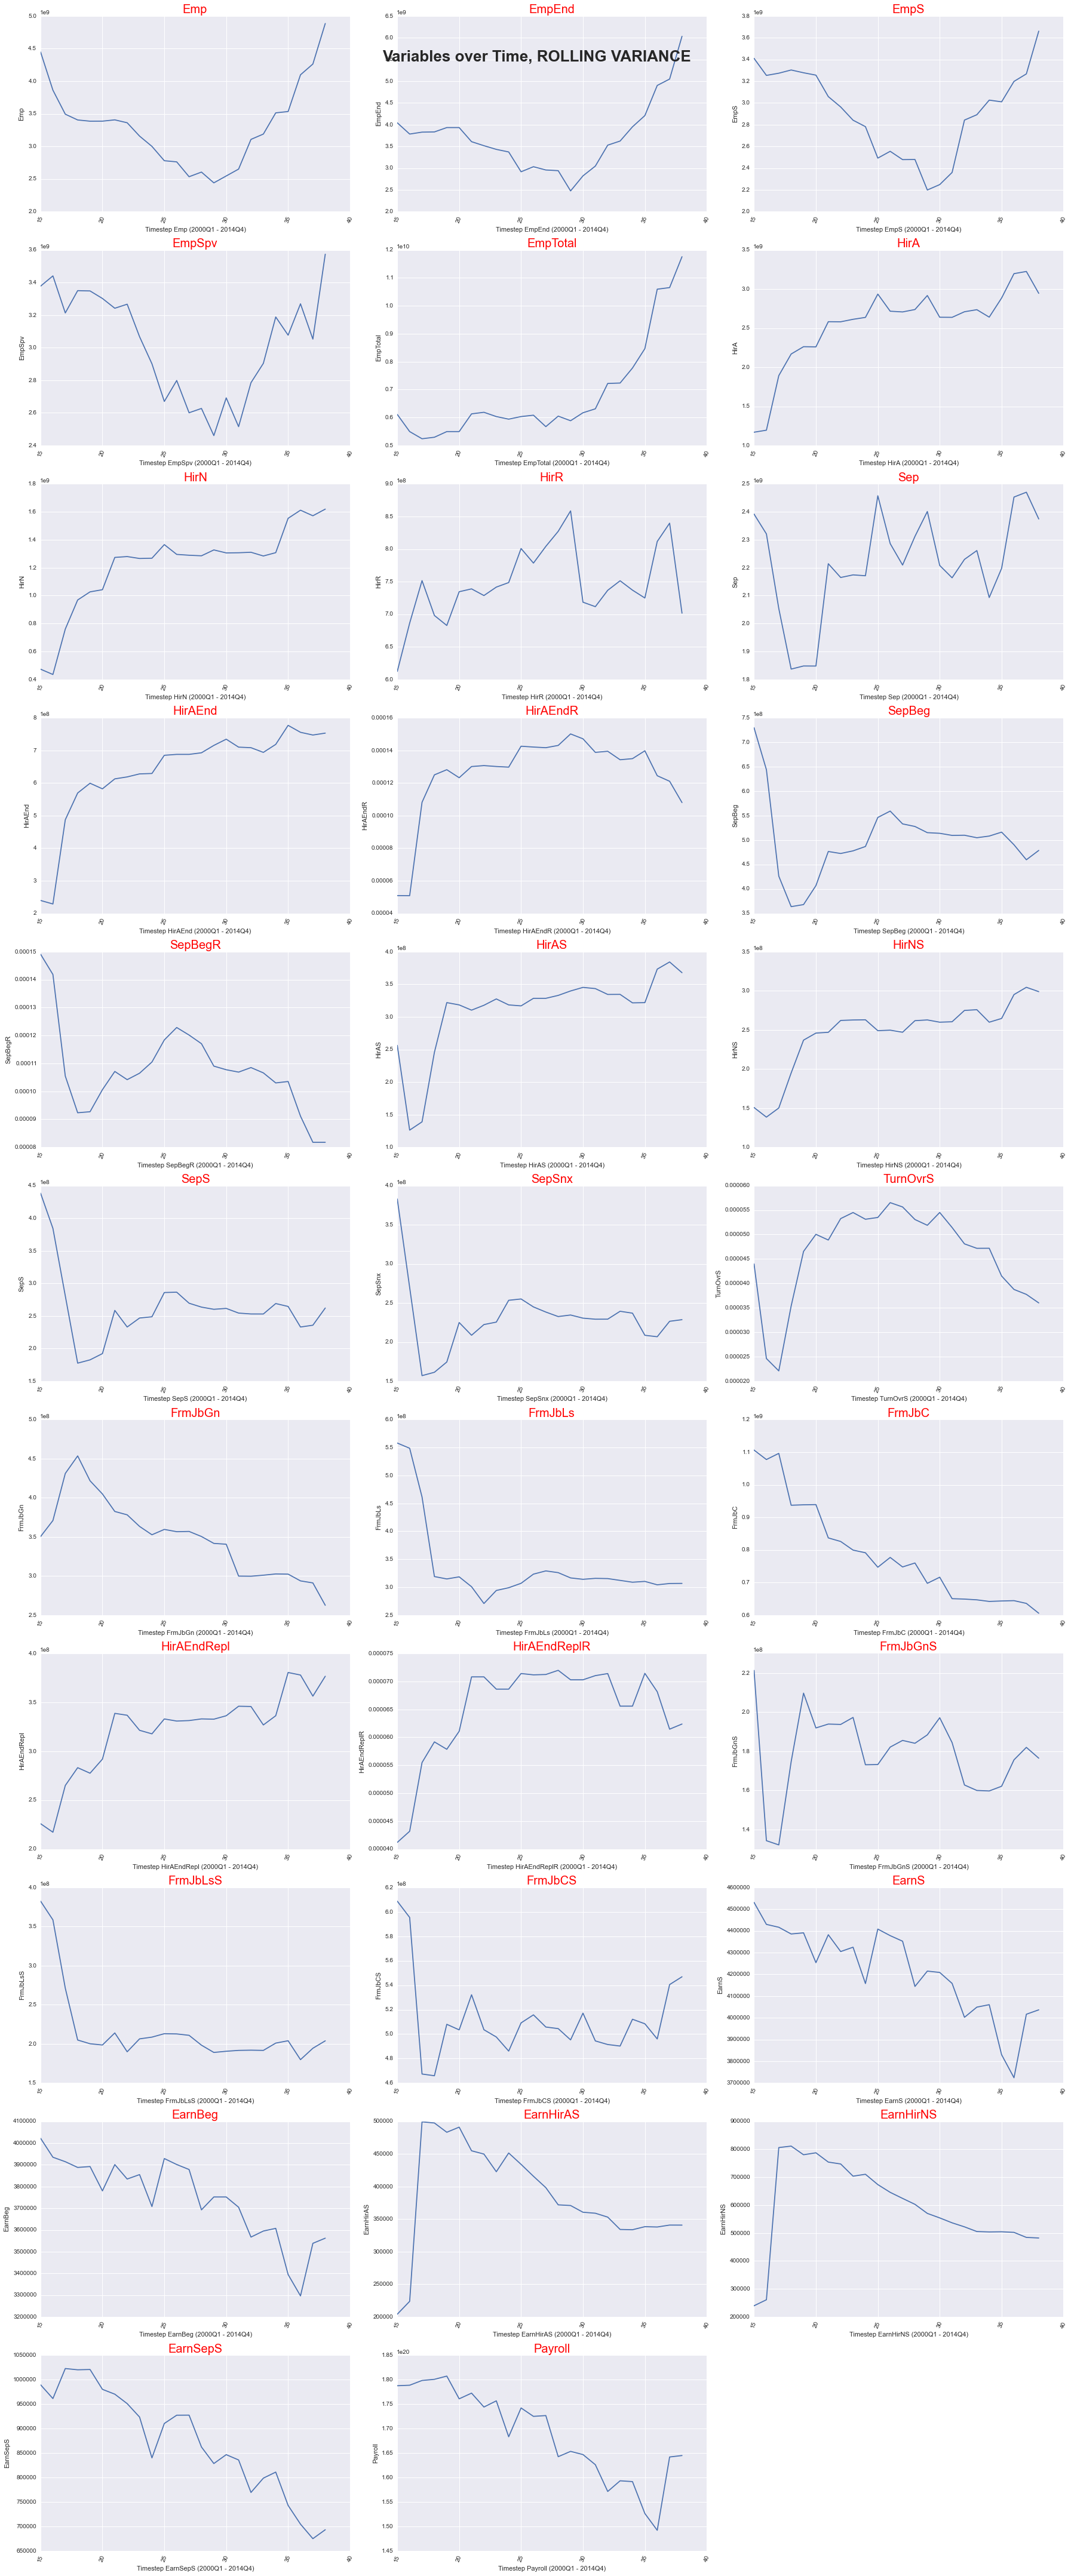

In [160]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, ROLLING VARIANCE', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(np.arange(len(data[i])), pd.rolling_var(data[i], 30, min_periods=None, freq=None, center=True), label = 'all data')
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

In [161]:
#variables for the PCA

inputs = ['EmpTotal', 'HirN', 'HirR', 'HirAEndR', 'SepBegR', 'HirAS', 'FrmJbC', 
          'HirAEndReplR', 'EarnS', 'EarnHirNS']

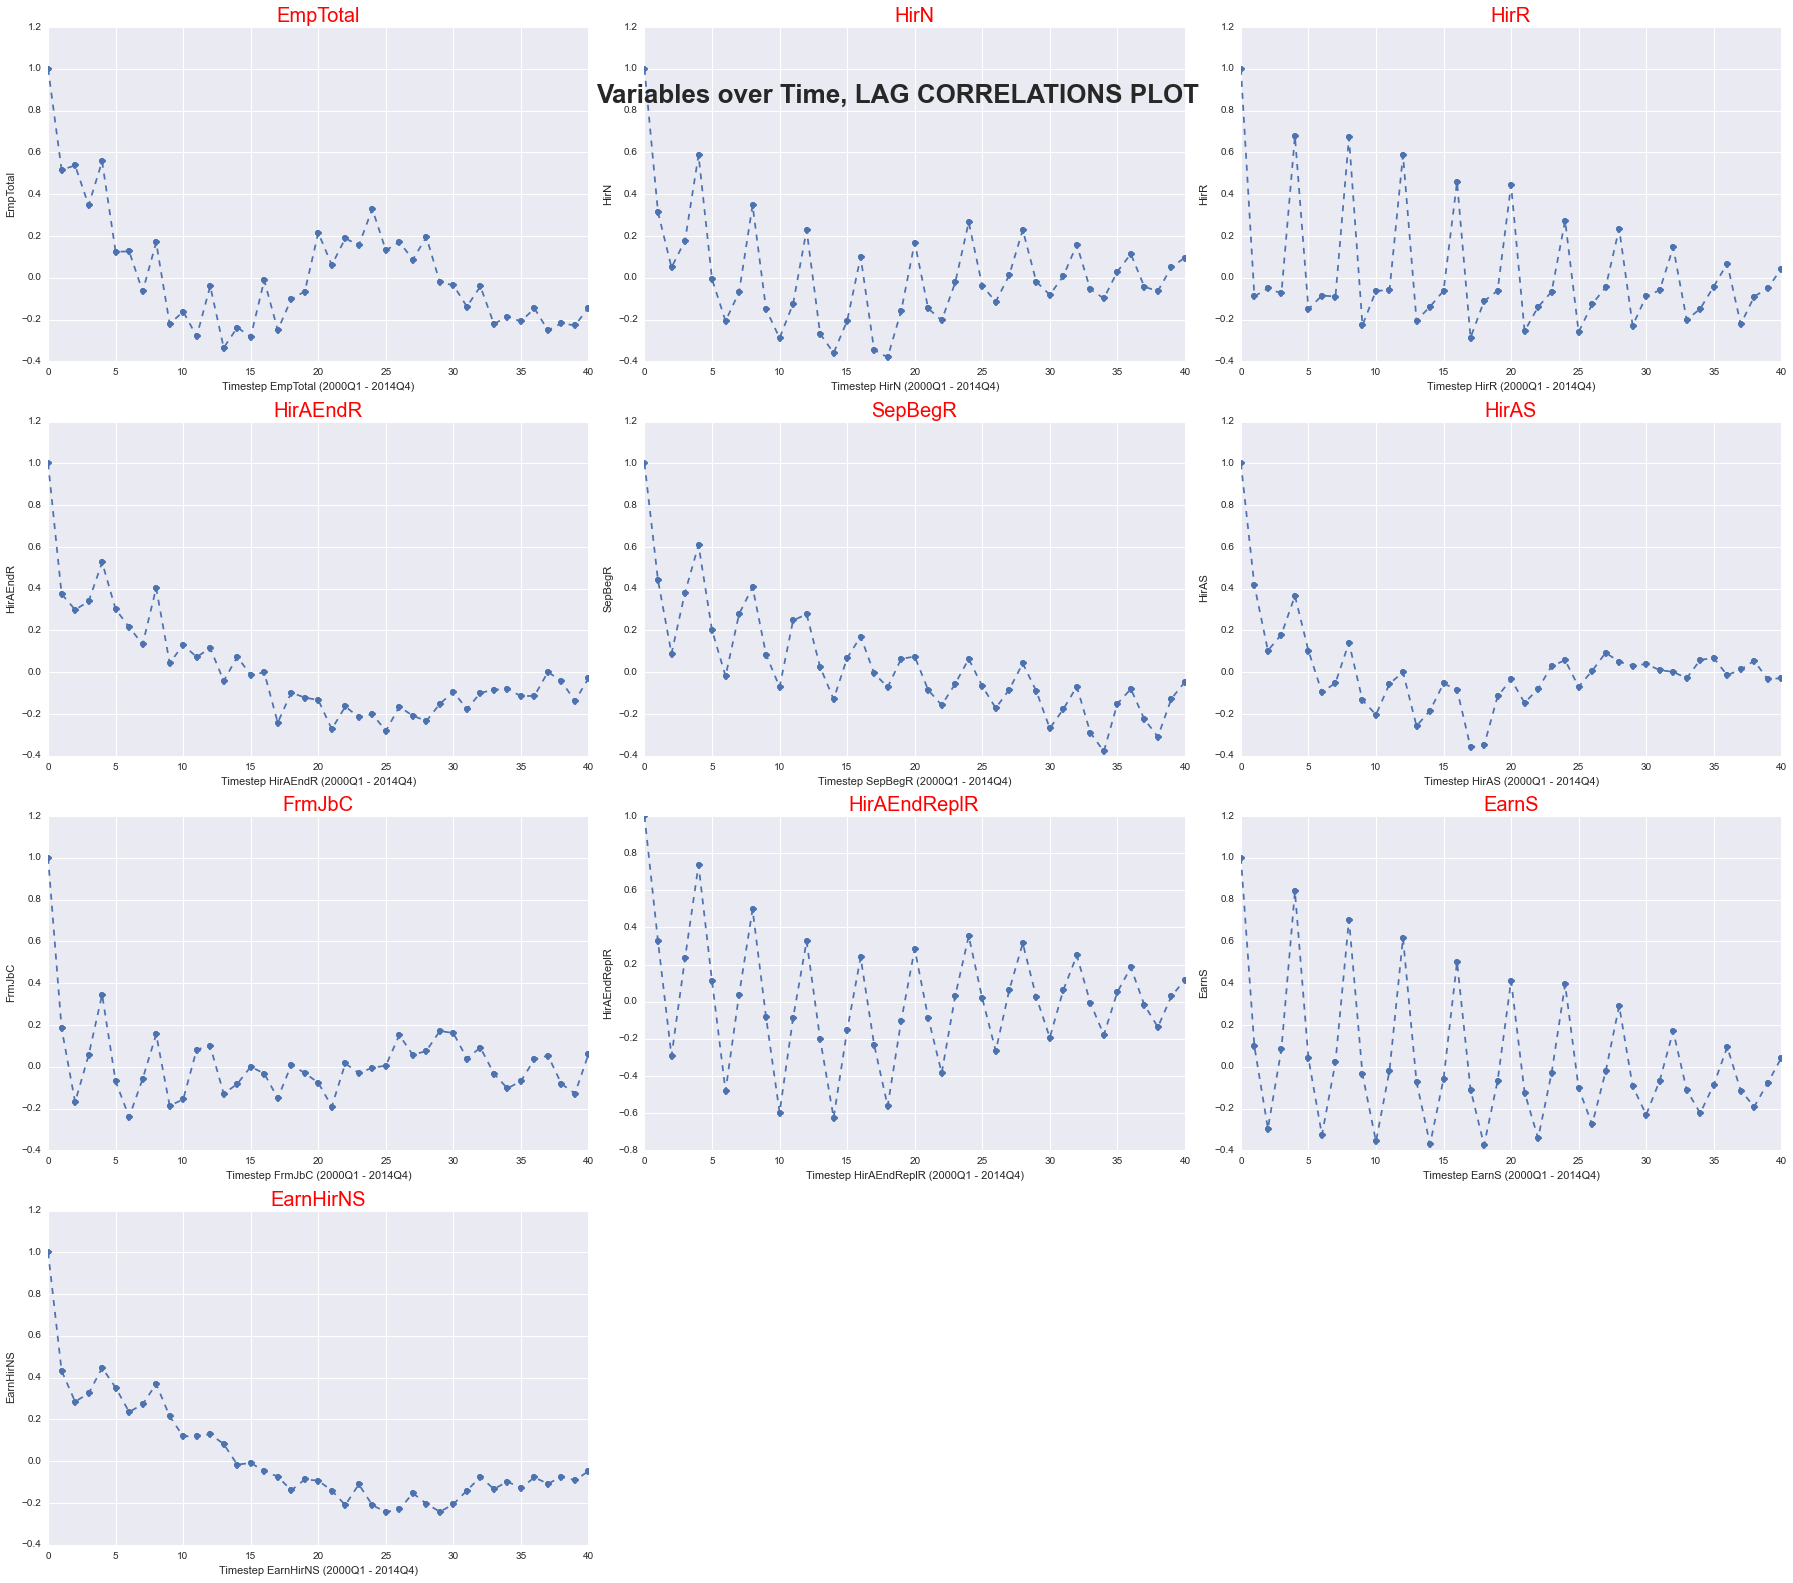

In [162]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf


fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, LAG CORRELATIONS PLOT', fontweight='bold', fontsize=26)

x = 1
#for i in cols:
for i in inputs:
    
    lag_correlations = acf(data[i].iloc[1:])  
    lag_partial_correlations = pacf(data[i].iloc[1:])
    
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(lag_correlations, marker='o', linestyle='--')  
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

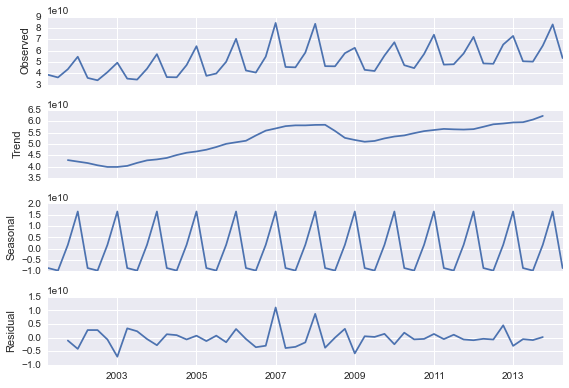

In [163]:
#check decomposition between the observed data, the linear (or non linear) trend
# the seasonal period, and the residuals leftover

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Payroll'])
# fig = plt.figure()  
# fig = decomposition.plot()

fig = pl.figure()  
fig = decomposition.plot()
pl.title = ('Payroll')

/usr/local/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


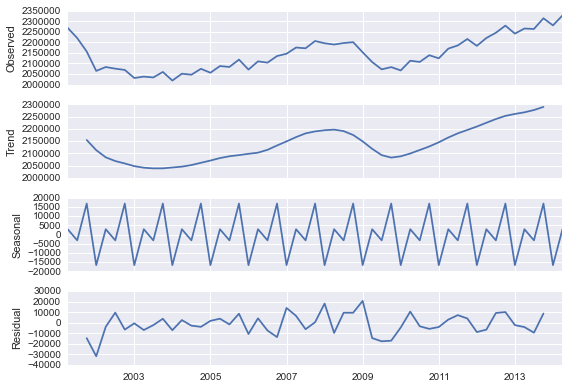

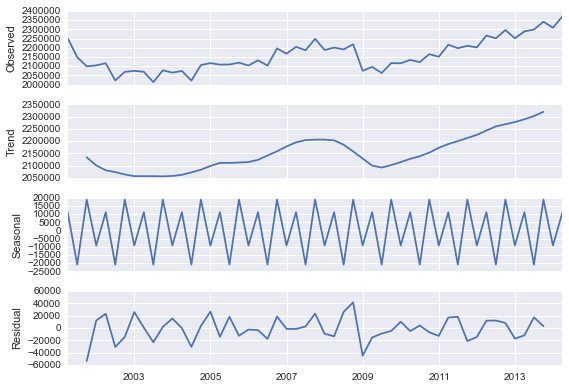

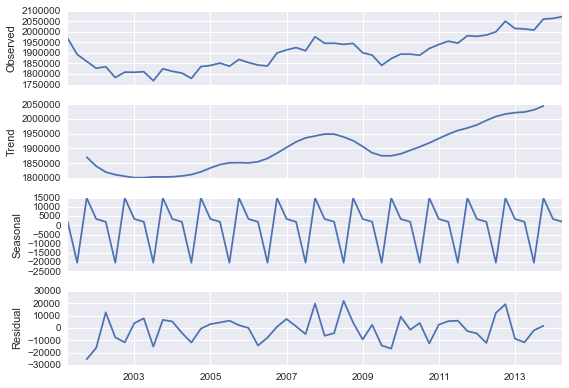

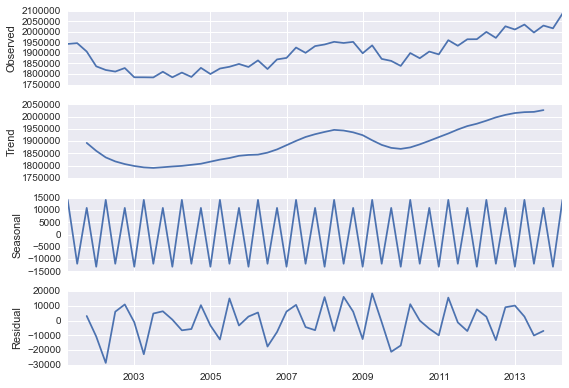

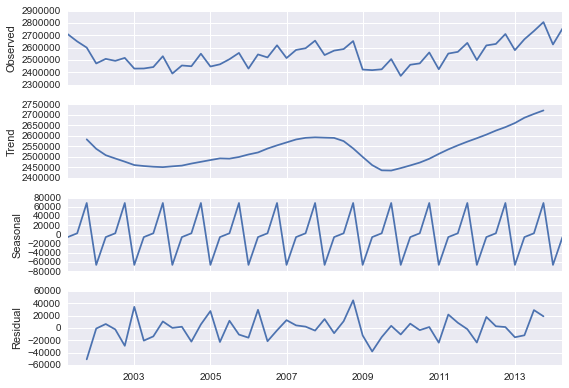

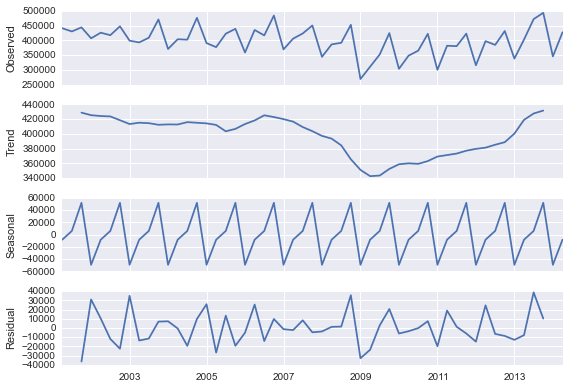

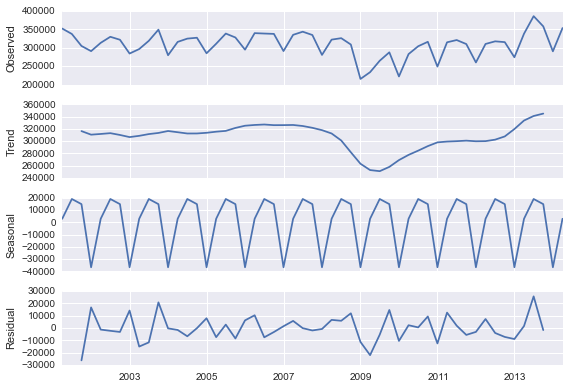

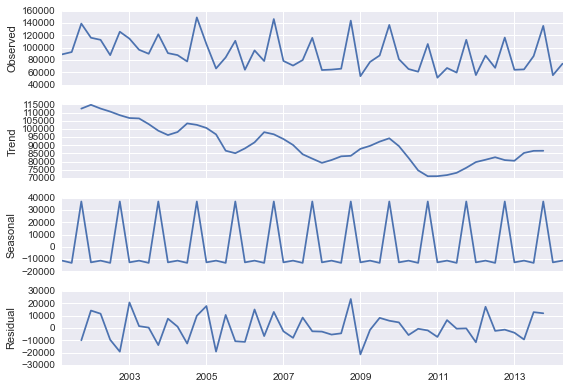

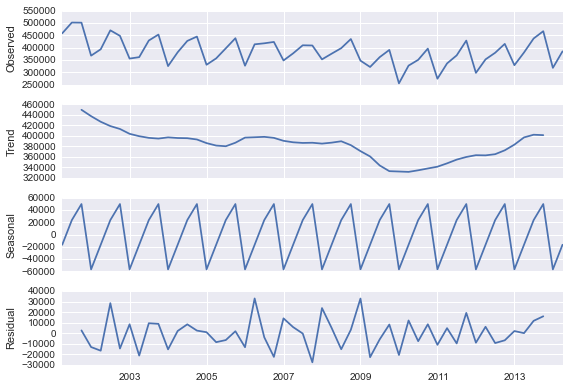

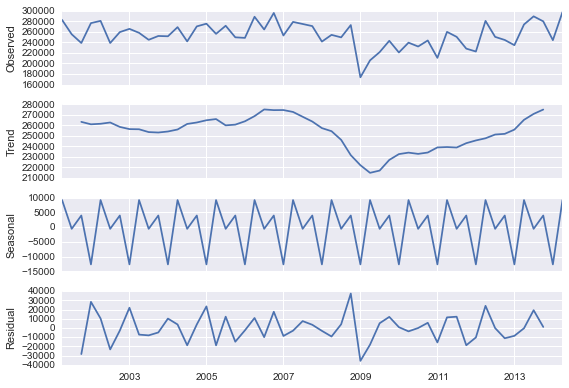

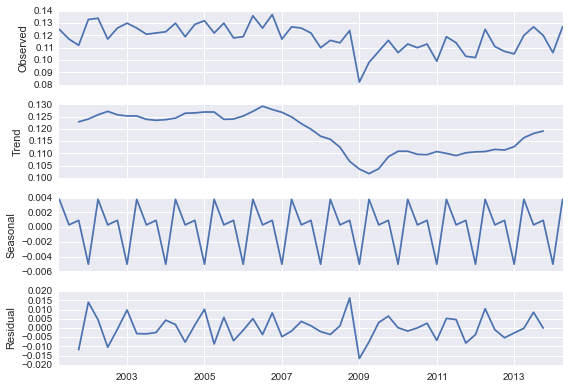

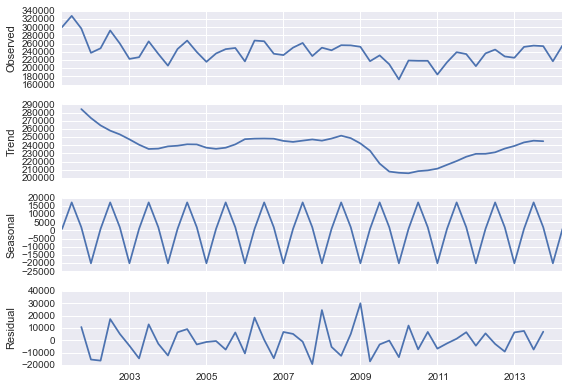

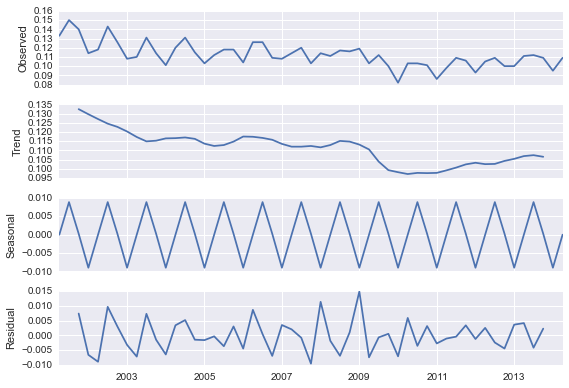

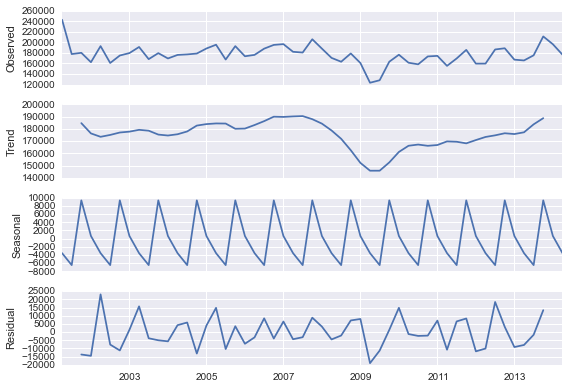

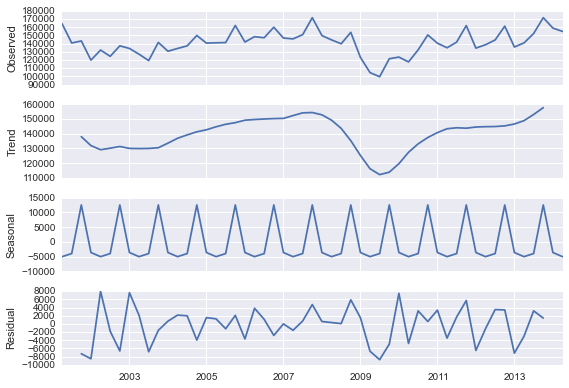

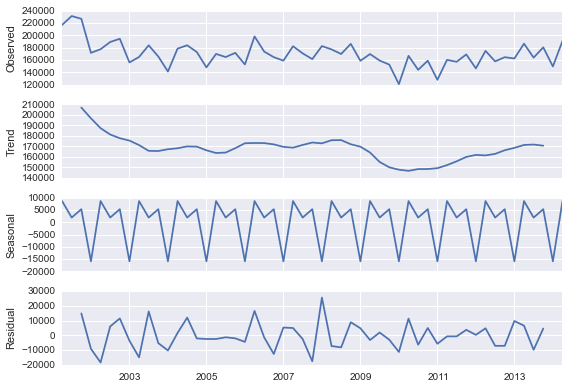

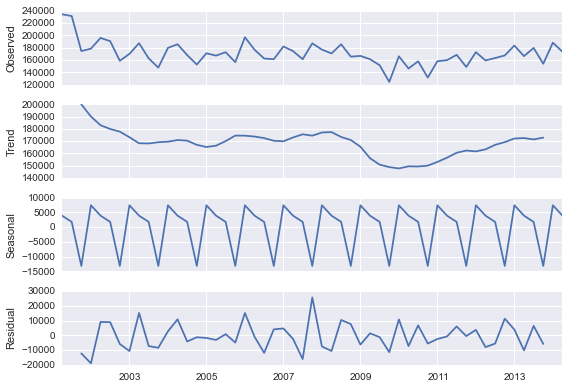

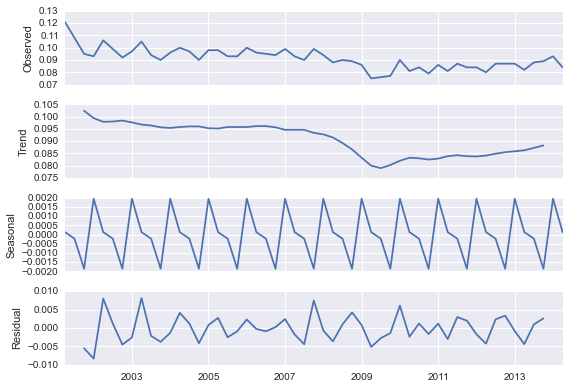

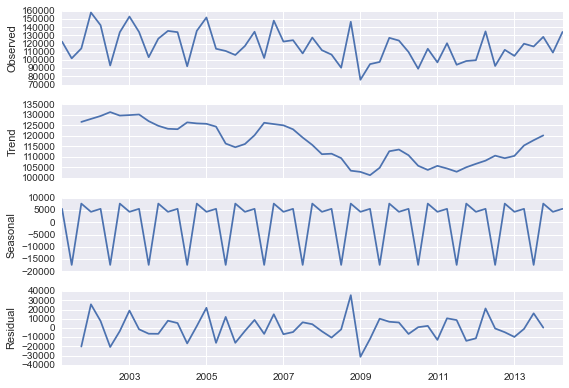

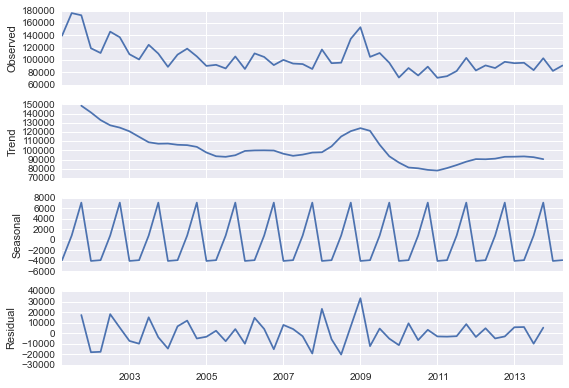

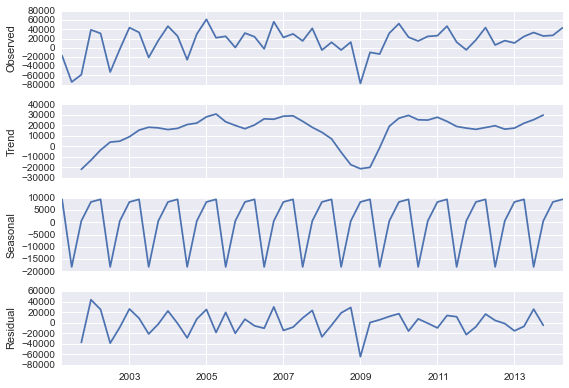

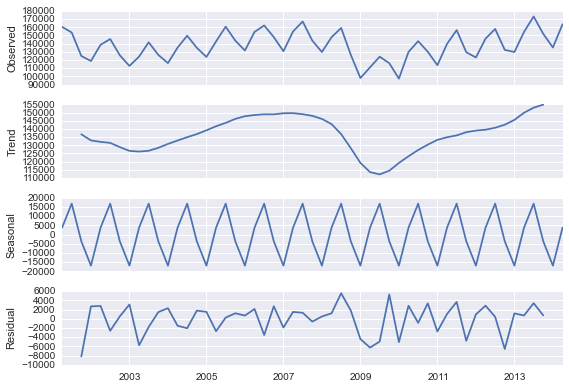

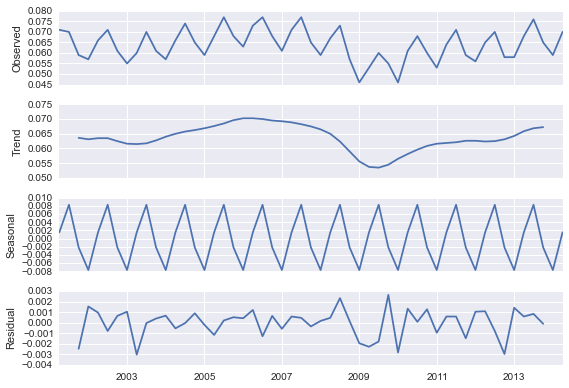

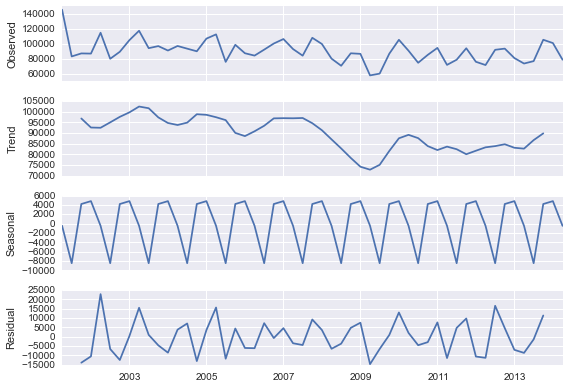

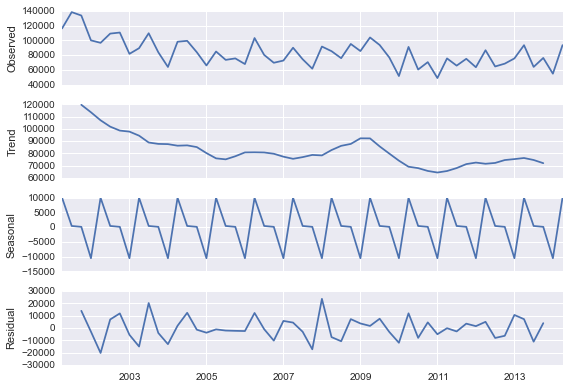

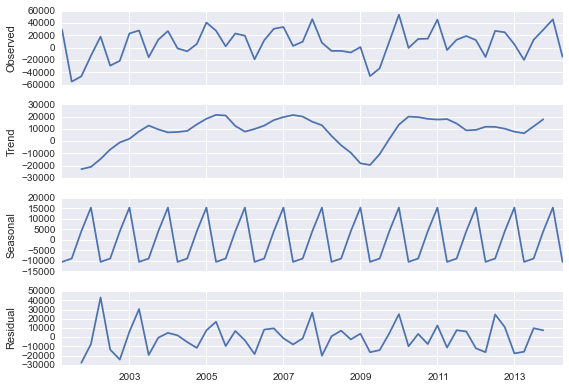

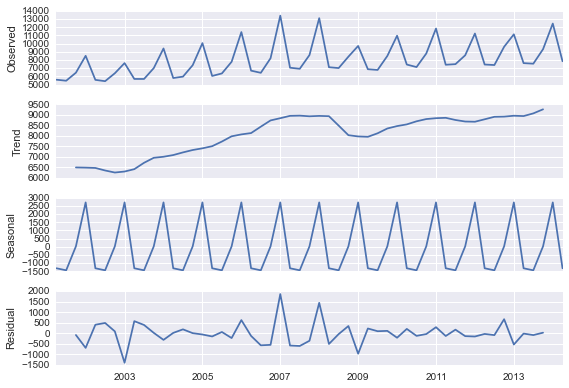

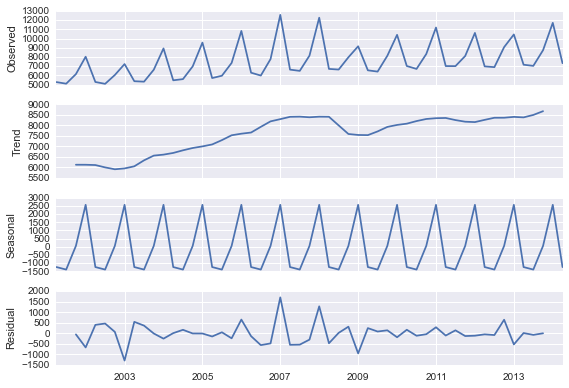

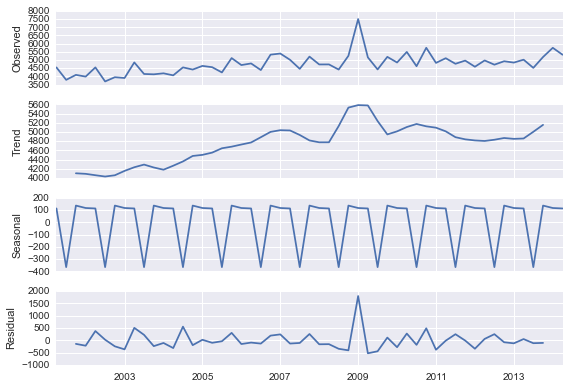

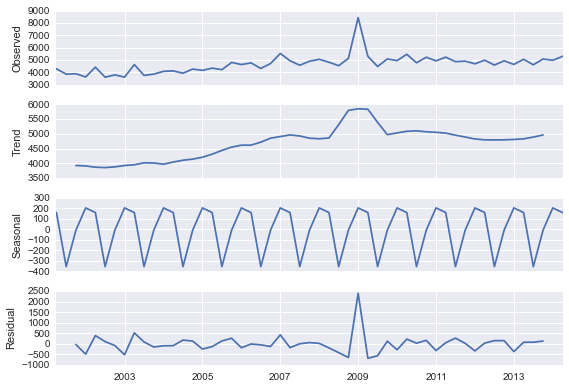

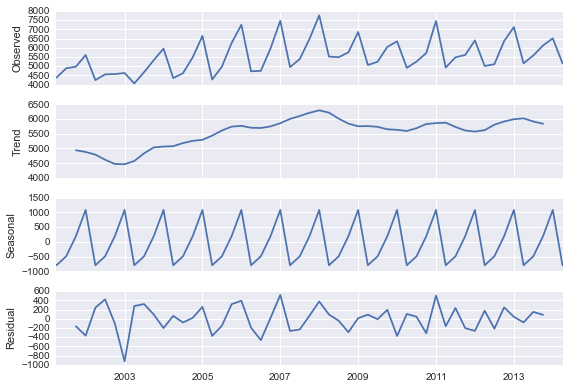

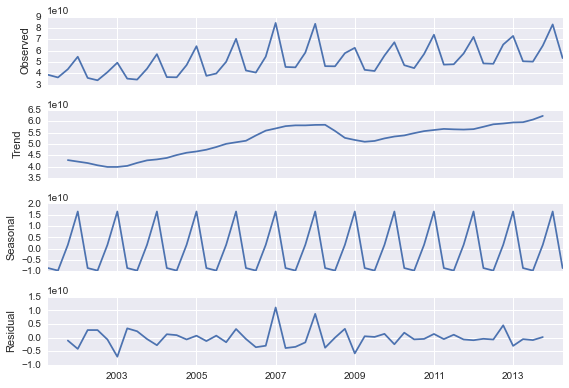

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, DECOMPOSITION PLOT', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    
    decomposition = seasonal_decompose(data[i])  
 
    #ax1 = fig.add_subplot(11,3,x)
    #fig.tight_layout()
    #ax1 = 
    decomposition.plot()  
    x +=1

In [165]:
# data.head()
# data.drop(['index'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


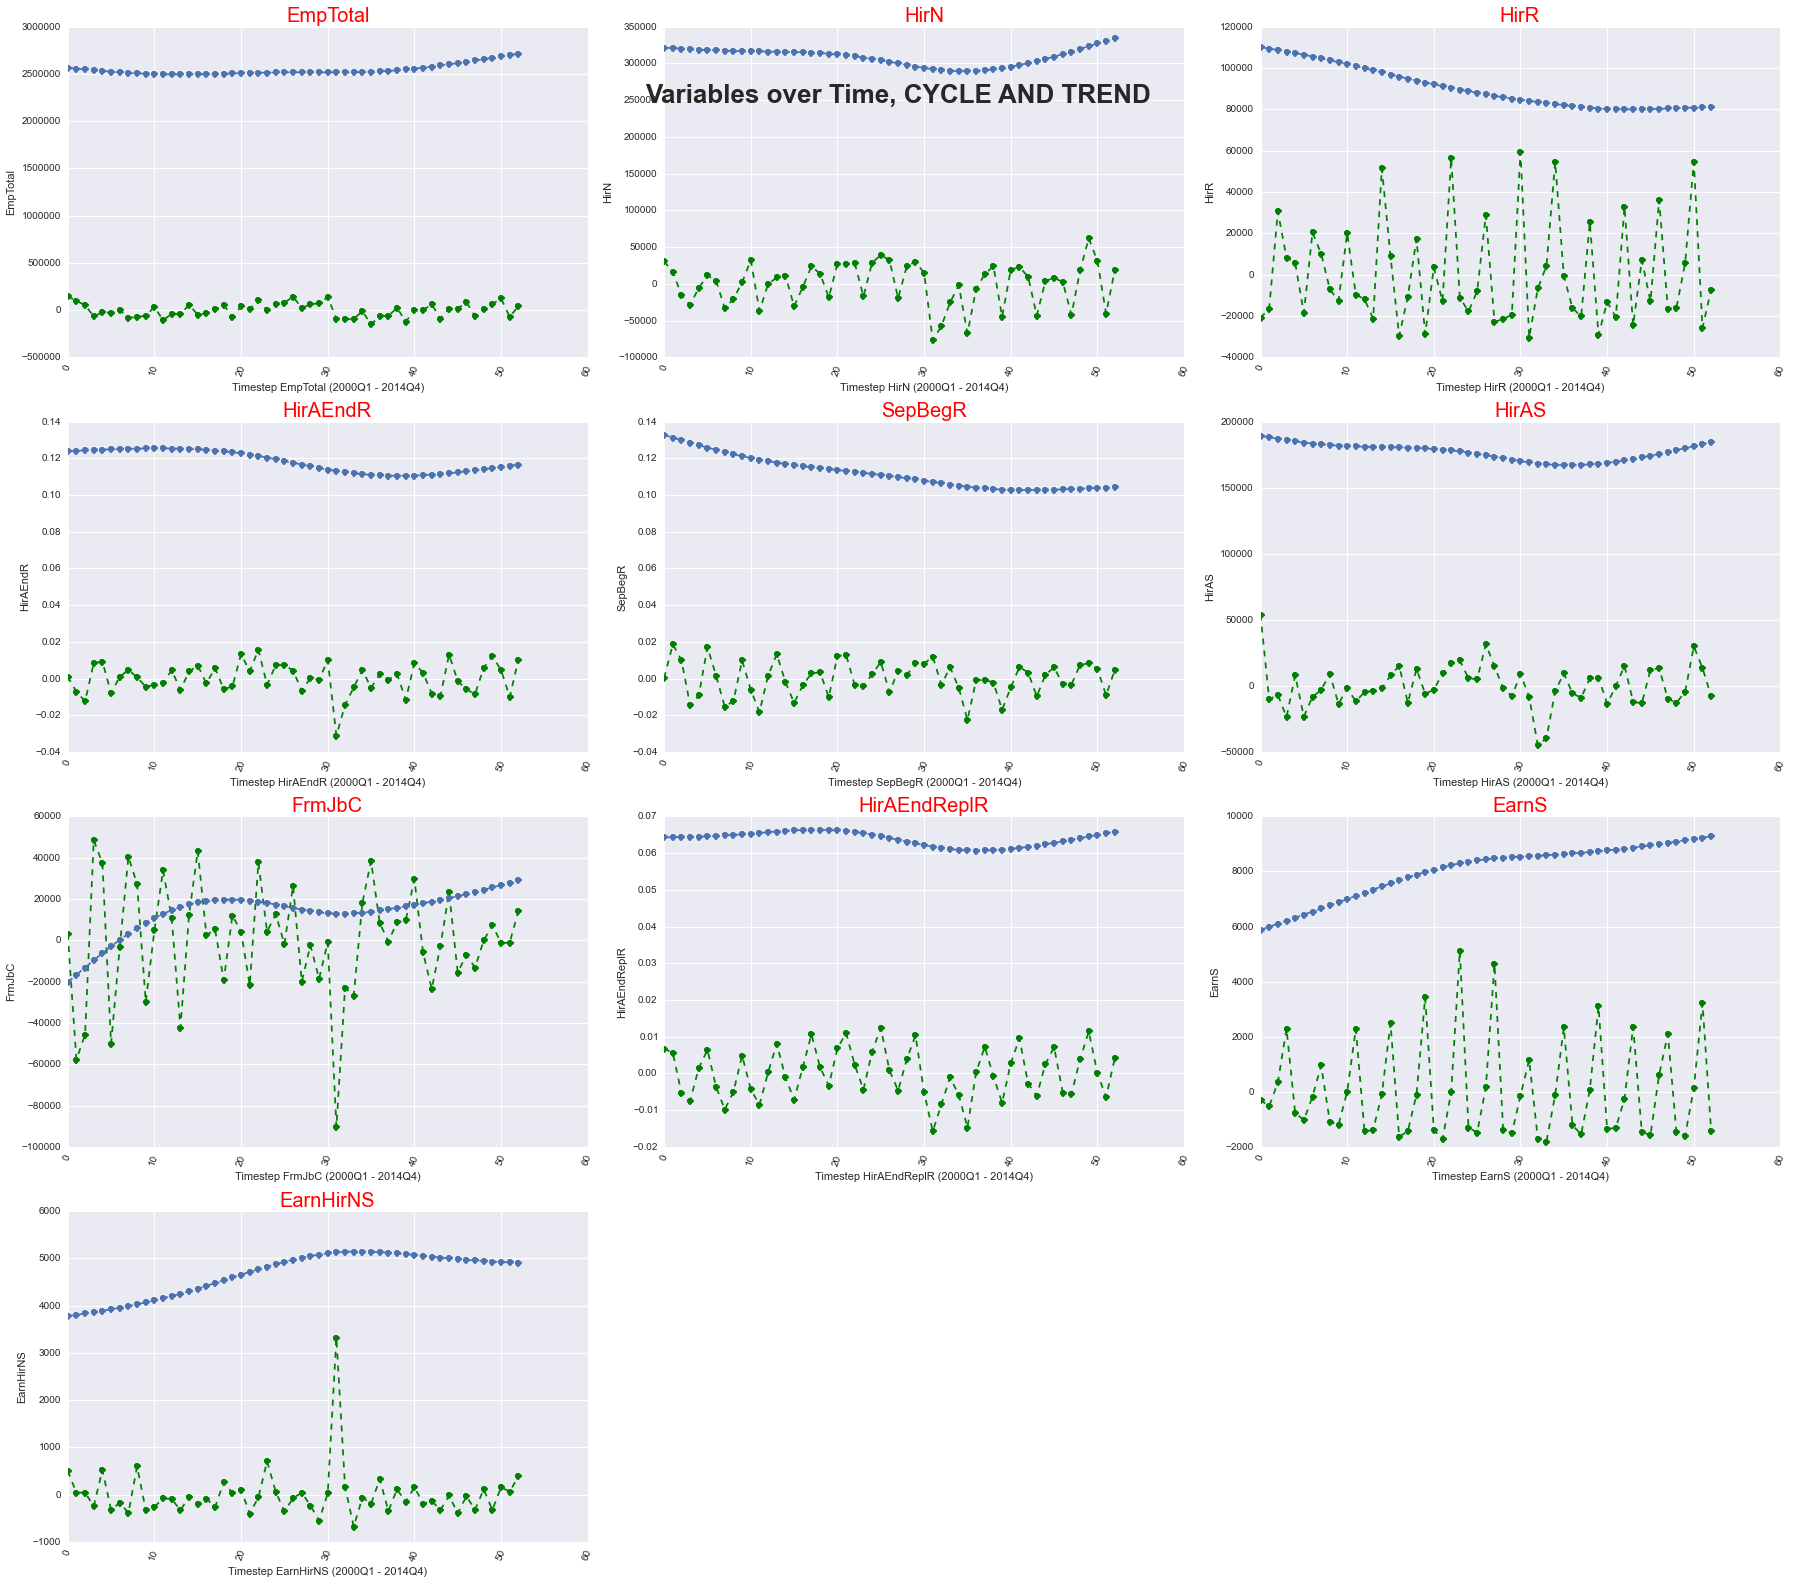

In [226]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, CYCLE AND TREND', fontweight='bold', fontsize=26)

cycles = {}

x = 1
#for i in cols:
for i in inputs:
    
    cycle, trend = sm.tsa.filters.hpfilter(data[i], 1600)
    cycles[i] = cycle
    
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(cycle, marker='o', linestyle='--', color = 'g')  
    ax1.plot(trend, marker='o', linestyle='--')  
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    ax1.legend()
    x +=1


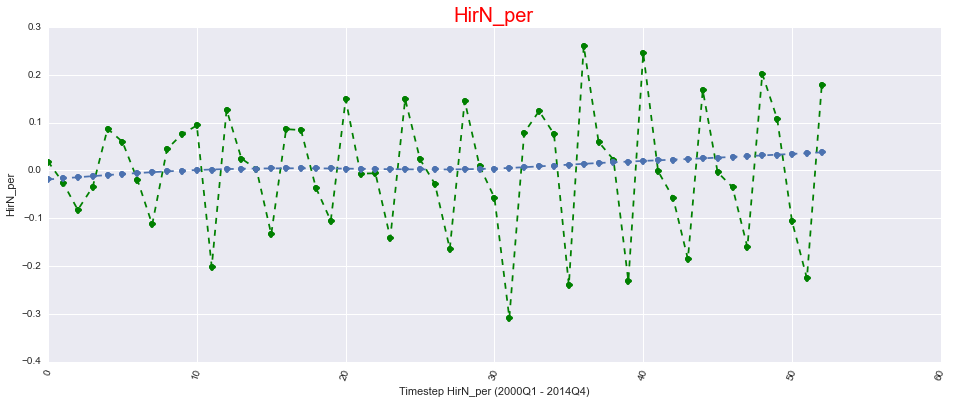

In [227]:
cycle, trend = sm.tsa.filters.hpfilter(data['HirN_per'], 1600)
HirN_per_trend = trend
fig, (ax1) = pl.subplots(figsize=(16,6), nrows=1, ncols=1)


ax1.plot(cycle, marker='o', linestyle='--', color = 'g')  
ax1.plot(trend, marker='o', linestyle='--')  
ax1.set_xlabel('Timestep HirN_per (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirN_per')
pl.xticks(rotation = 70)
ax1.set_title('HirN_per', fontsize=20, color='r')


In [228]:
#save cycles into a new dataframe
input_cycles = pd.DataFrame(cycles)

In [229]:
input_cycles['HirN_per'] = data['HirN_per'].values

In [230]:
#Covariance Matrix
input_cycles.cov()

EarnHirNS           EarnS          EmpTotal  \
EarnHirNS       297,817.690     160,095.241    -2,295,915.463   
EarnS           160,095.241   3,188,240.708   -38,631,742.381   
EmpTotal     -2,295,915.463 -38,631,742.381 5,423,766,303.047   
FrmJbC       -4,319,728.281   8,010,543.488  -134,188,606.117   
HirAEndR             -1.775          -5.217           259.482   
HirAEndReplR         -1.330          -8.093           245.691   
HirAS         1,251,206.273   6,757,001.622   616,521,672.728   
HirN         -5,156,720.701 -30,899,173.644 1,726,104,443.271   
HirR         -1,456,527.872  -2,208,019.778   884,892,586.453   
SepBegR               0.362          -9.012           324.338   
HirN_per            -16.689        -181.798         2,441.442   

                       FrmJbC  HirAEndR  HirAEndReplR           HirAS  \
EarnHirNS      -4,319,728.281    -1.775        -1.330   1,251,206.273   
EarnS           8,010,543.488    -5.217        -8.093   6,757,001.622   
EmpTotal     -134,188,606.117   259.482       245.691 616,521,672.728   
FrmJbC        737,598,245.608   159.004       -25.109  89,707,702.420   
HirAEndR              159.004     0.000         0.000          21.166   
HirAEndReplR          -25.109     0.000         0.000           6.945   
HirAS          89,707,702.420    21.166         6.945 269,223,214.877   
HirN           32,078,760.058   155.857       166.931 135,007,436.728   
HirR          170,581,697.637    75.940       -31.628  83,371,271.707   
SepBegR              -189.948    -0.000         0.000         -19.873   
HirN_per              501.469     0.001         0.001        -569.564   

                          HirN            HirR  SepBegR  HirN_per  
EarnHirNS       -5,156,720.701  -1,456,527.872    0.362   -16.689  
EarnS          -30,899,173.644  -2,208,019.778   -9.012  -181.798  
EmpTotal     1,726,104,443.271 884,892,586.453  324.338 2,441.442  
FrmJbC          32,078,760.058 170,581,697.637 -189.948   501.469  
HirAEndR               155.857          75.940   -0.000     0.001  
HirAEndReplR           166.931         -31.628    0.000     0.001  
HirAS          135,007,436.728  83,371,271.707  -19.873  -569.564  
HirN           880,950,985.653 191,813,350.574  142.575 2,334.277  
HirR           191,813,350.574 626,652,260.550  -12.730    51.140  
SepBegR                142.575         -12.730    0.000     0.000  
HirN_per             2,334.277          51.140    0.000     0.017

**Principle Component Analysis, v1**

(using all columns -- doing with sklearn)

In [231]:
#convert dataframe to a numpy array
sk_data= input_cycles.as_matrix()
print(sk_data.shape)

#drop the first three columns: period, year, quarter -- all that remains are the numeric indicator columns
y = sk_data[:,-1]
X = sk_data[:,:-1]
# print(X.shape)
# print(y.shape)



(53, 11)


In [232]:
#CYCLES OF DATA:

principles = 3

pca = sk.decomposition.PCA(n_components = principles)
pca.fit(X)
X_t = pca.transform(X)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 

#get the weights of each of the features by vector space
i = np.identity(X.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=inputs)


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)
    

PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:
 [ 0.783  0.106  0.059]
PCA PARAMETERS:
 {'n_components': 3, 'whiten': False, 'copy': True} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
EmpTotal     -0.001  0.005 -0.007
HirN         -0.007 -0.012 -0.023
HirR          0.931  0.074 -0.067
HirAEndR     -0.014 -0.888  0.350
SepBegR      -0.000 -0.000  0.000
HirAS        -0.000  0.000  0.000
FrmJbC        0.106 -0.122  0.037
HirAEndReplR  0.309  0.001  0.581
EarnS         0.159 -0.437 -0.731
EarnHirNS    -0.000  0.000  0.000


In [233]:
#NORMALIZED CYCLES OF DATA:

X_norm = sk.preprocessing.normalize(X, norm='l2', axis=0, copy=True)

principles = 3

pca = sk.decomposition.PCA(n_components = principles)
pca.fit(X_norm)
X_norm_t = pca.transform(X_norm)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 

#get the weights of each of the features by vector space
i = np.identity(X_norm.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=inputs)


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)

PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:
 [ 0.379  0.244  0.157]
PCA PARAMETERS:
 {'n_components': 3, 'whiten': False, 'copy': True} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
EmpTotal     -0.179  0.201 -0.464
HirN         -0.357 -0.193 -0.262
HirR          0.404 -0.067 -0.424
HirAEndR     -0.008 -0.597  0.206
SepBegR       0.329 -0.399  0.197
HirAS         0.443  0.151  0.203
FrmJbC        0.107 -0.248 -0.555
HirAEndReplR  0.494 -0.042 -0.043
EarnS         0.142 -0.313 -0.305
EarnHirNS     0.312  0.466 -0.107


In [234]:
#print('PCA WEIGHTS, PC-1 >0.1: \n', weights[weights['PC-1'].abs() > 0.1])

In [236]:
regress = pd.DataFrame(X_norm_t, columns=['PC_1', 'PC_2', 'PC_3'])
regress['y'] = y
regress['y'] = regress['y'].convert_objects(convert_numeric=True)

In [237]:
X1 = regress[['PC_1', 'PC_2', 'PC_3']]
y1 = regress['y']

In [243]:
X1 = sm.add_constant(X1)
est = sm.OLS(y1, X1).fit()

b = est.params

pca_HirN_per = b[0] + b[1]*X_norm_t[:,0] + b[2]*X_norm_t[:,1] + b[3]*X_norm_t[:,2];


est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     24.80
Date:                Tue, 24 Nov 2015   Prob (F-statistic):           6.63e-10
Time:                        14:04:15   Log-Likelihood:                 57.647
No. Observations:                  53   AIC:                            -107.3
Df Residuals:                      49   BIC:                            -99.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0086      0.012      0.740      0.463        -0.015     0.032
PC_1           0.3100      0.044      7.119      0.000         0.222     0.397
PC_2           0.0240      0.054      0.441      0.661        -0.085     0.133
PC_3           0.3280      0.068      4.851      0.000         0.192     0.464
==============================================================================
Omnibus:                        3.928   Durbin-Watson:                   2.734
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                3.337
Skew:                           0.614   Prob(JB):                        0.189
Kurtosis:                       3.066   Cond. No.                         5.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [239]:
regress2 = pd.DataFrame(X_norm, columns=inputs)

regress2['y'] = y
regress2['y'] = regress2['y'].convert_objects(convert_numeric=True)


X2 = regress2.ix[:,0:-1]
y2 = regress2['y']

X2 = sm.add_constant(X2)
est2 = sm.OLS(y2, X2).fit()

est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     19.29
Date:                Tue, 24 Nov 2015   Prob (F-statistic):           1.19e-12
Time:                        13:50:52   Log-Likelihood:                 78.792
No. Observations:                  53   AIC:                            -135.6
Df Residuals:                      42   BIC:                            -113.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.0086      0.008      1.021      0.313        -0.008     0.026
EmpTotal         0.0106      0.085      0.124      0.902        -0.162     0.183
HirN            -0.5610      0.101     -5.578      0.000        -0.764    -0.358
HirR            -0.0401      0.159     -0.252      0.802        -0.361     0.281
HirAEndR         2.3769      0.967      2.458      0.018         0.426     4.328
SepBegR         -1.2646      0.662     -1.910      0.063        -2.601     0.072
HirAS           -0.3749      0.235     -1.595      0.118        -0.849     0.099
FrmJbC          -0.2568      0.097     -2.654      0.011        -0.452    -0.062
HirAEndReplR     0.5381      0.216      2.489      0.017         0.102     0.974
EarnS           -0.2029      0.127     -1.592      0.119        -0.460     0.054
EarnHirNS        1.6698      0.708      2.359      0.023         0.242     3.098
==============================================================================
Omnibus:                        1.962   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.151
Skew:                           0.149   Prob(JB):                        0.563
Kurtosis:                       3.657   Cond. No.                         161.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
b2 = est2.params

est_HirN_per = b2[0] + b2[1]*X_norm[:,0] + b2[2]*X_norm[:,1] + b2[3]*X_norm[:,2] + b2[4]*X_norm[:,3] 
+ b2[5]*X_norm[:,4] + b2[6]*X_norm[:,5] + b2[7]*X_norm[:,6] + b2[8]*X_norm[:,7]
+ b2[9]* X_norm[:,8] + b2[10]*X_norm[:,9];


<bound method AxesSubplot.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x19fb55390>>

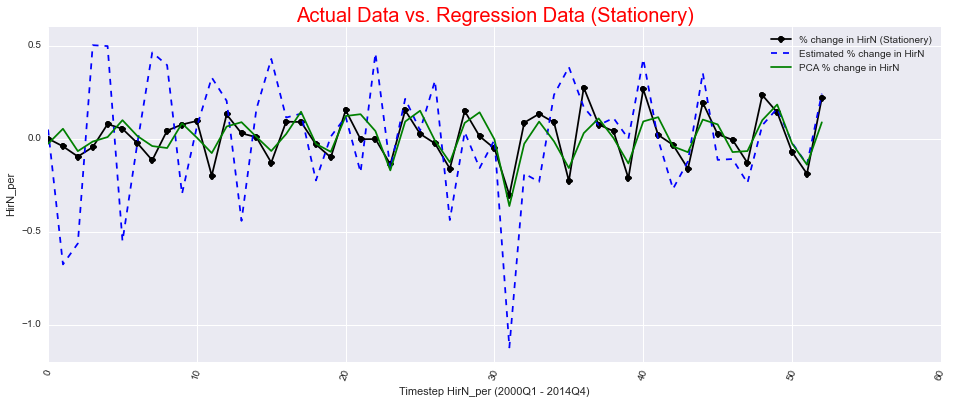

In [248]:
fig, (ax1) = pl.subplots(figsize=(16,6), nrows=1, ncols=1)


ax1.plot(y2, marker='o', linestyle='-', color = 'k', label = '% change in HirN (Stationery)')  
ax1.plot(est_HirN_per, linestyle='--', color = 'b', label = 'Estimated % change in HirN')  
ax1.plot(pca_HirN_per, linestyle='-', color = 'g', label = 'PCA % change in HirN')  

ax1.set_xlabel('Timestep HirN_per (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirN_per')
pl.xticks(rotation = 70)
ax1.set_title('Actual Data vs. Regression Data (Stationery)', fontsize=20, color='r')
pl.legend()

ax1.legend
